In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RANSACRegressor

In [2]:
df = pd.read_csv('calibration_data.csv')

# Preprocessing
df['Encoder'][df['Encoder'] < 500] += 1024
df['Encoder'] -= 500
df.sort_values('Encoder', inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

C:\Users\ad\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Encoder,kanan_x1,kanan_x2,kanan_theta_deg,kiri_x1,kiri_x2,kiri_theta_deg,theta_mean_deg
0,32,20.6,3.2,-38.420532,2.1,20.8,-41.901893,-40.161212
1,50,18.6,1.9,-36.614539,3.3,20.6,-38.159820,-37.387179
2,100,16.5,1.8,-31.668243,3.3,19.4,-35.099632,-33.383938
3,100,17.3,2.6,-31.668243,2.4,18.3,-34.600933,-33.134588
4,150,13.9,2.0,-25.150663,3.6,17.6,-30.000000,-27.575332


> $$\displaystyle{\cot(\delta)=\frac{\cot(\delta_l)+\cot(\delta_r)}{2}}$$
$$\displaystyle{\tan(\delta)=\frac{2 \tan(\delta_l)\tan(\delta_r)}{\tan(\delta_l) + \tan(\delta_r)}}$$

In [3]:
δl = df['kiri_theta_deg'].values * np.pi / 180. # Radian
δr = df['kanan_theta_deg'].values * np.pi / 180. # Radian
δ = np.arctan(2*np.tan(δl)*np.tan(δr) / (np.tan(δl)+np.tan(δr))) # Radian
δ = δ[:, np.newaxis] # Radian
δl = δl * 180. / np.pi # Degree
δr = δr * 180. / np.pi # Degree
δ = δ * 180. /np.pi # Degree

In [4]:
# We use RANSAC (Random Sample Consensus) to make the linear regression more robust to the outlier
X = df['Encoder'].values[:, np.newaxis]
model = RANSACRegressor().fit(X, δ)
pred = model.predict(X)
inlier_mask = model.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print("The number of outliers: {}".format(np.sum(outlier_mask)))

The number of outliers: 1


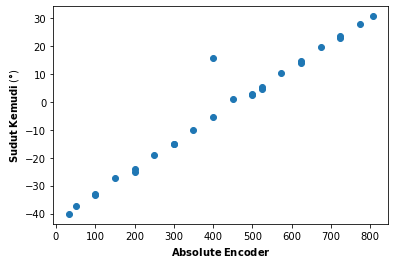

In [5]:
plt.scatter(df['Encoder'], δ, label='Sudut Kemudi')
plt.xlabel(r'$\mathbf{Absolute\:Encoder}$')
plt.ylabel(r'$\mathbf{Sudut\:Kemudi\:\left(\degree\right)}$')
plt.show()

In [6]:
print(model.estimator_.coef_[0,0])
print(model.estimator_.intercept_[0])
print(model.score(X, δ))

0.09053715700006351
-42.12905785478028
0.9600205689051575


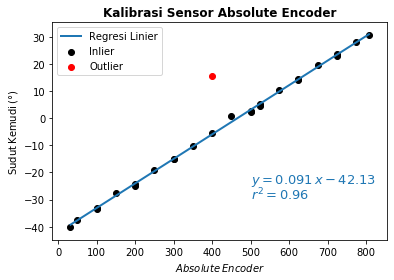

In [7]:
plt.plot(X, model.predict(X), linewidth=2.0, label='Regresi Linier')
plt.scatter(X[inlier_mask], δ[inlier_mask], color='black', label=r'Inlier')
plt.scatter(X[outlier_mask], δ[outlier_mask], color='red', label=r'Outlier')
plt.legend()
plt.xlabel(r'$\mathit{Absolute\:Encoder}$')
plt.ylabel(r'$\mathrm{Sudut\:Kemudi\:}\left(\degree\right)$', fontweight="bold")
plt.title(r'Kalibrasi Sensor Absolute Encoder', fontweight="bold")
pos = [500,-30.]
plt.text(pos[0], pos[1]+6, r'$y={:.2}\,x-{:.4}$'.format(model.estimator_.coef_[0,0], np.abs(model.estimator_.intercept_[0])), fontsize=13, color='tab:blue')
plt.text(pos[0], pos[1], r'$r^2={:.4}$'.format(model.score(X, δ)), fontsize=13, color='tab:blue')
plt.savefig('kalibrasi_absolute_encoder.png', dpi=400, transparent=True)
plt.show()

In [10]:
np.max(δ)

30.600302040744218